# Random Forest

## Setup

In [1]:
# Imports
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 160
colors = sns.color_palette("viridis", 10)

import utilities as utils
from utilities import *

In [2]:
# Pamateters
data_dir = "../data/preprocessed"
data_source_type = "gdansk" # ["gdansk", "physionet"]
splice_type = "constant" # ["complete", "constant", "random"]
label_type = "classification" # ["classification", "regression"]
simulation = True
max_size_cv = 40_000
max_size_fit = 80_000

In [3]:
# Auto adjustment
data_type = "simulated" if simulation else "original"

if simulation:
    N = 96
    simulated = 100
    data_source_type = "gdansk"
    splice_type = "constant"
else:
    N = 48
    simulated = None
    
read_path = f"{data_dir}/{data_type}_{data_source_type}_{splice_type}_features_{label_type}_milliseconds_"
y_name = "label" if label_type == "classification" else "age"
no_classes = 7 if data_source_type == "gdansk" else 6
classification = label_type=="classification"

relative_folder_dir = "../report/img/learning/"
basic_path = f"{data_type}_{data_source_type}_random_forest_{label_type}_{splice_type}_"
error_distribution_save_path = relative_folder_dir + basic_path + "error_distribution.png"
error_distribution_unbiased_save_path = relative_folder_dir + basic_path + "error_distribution_unbiased.png"

metrics_save_path = f"../report/results/{basic_path}metrics.txt"

## Data

In [4]:
%%time
train = pd.read_csv(read_path + "train.csv", index_col=0)
val = pd.read_csv(read_path + "val.csv", index_col=0)
test = pd.read_csv(read_path + "test.csv", index_col=0)

train = pd.concat([train, val])
del val

if train.shape[0] > max_size_cv:
    print(f"Reducing samples for cross validation from {train.shape[0]} to {max_size_cv}.")
    train_cv = train.sample(max_size_cv)
else:
    print(f"Keeping {train.shape[0]} samples for cross validation.")
    train_cv = train
    
if train.shape[0] > max_size_fit:
    print(f"Reducing samples for fitting from {train.shape[0]} to {max_size_fit}.")
    train_fit = train.sample(max_size_fit)
else:
    print(f"Keeping {train.shape[0]} samples for fitting.")
    train_fit = train
    
# Train CV
X_train_cv = train_cv.loc[:, train_cv.columns != y_name]
X_train_cv = X_train_cv.drop(columns=['tinn']) # Is all 'None'
Y_train_cv = train_cv[y_name]

# Train Fit
X_train_fit = train_fit.loc[:, train_fit.columns != y_name]
X_train_fit = X_train_fit.drop(columns=['tinn']) # Is all 'None'
Y_train_fit = train_fit[y_name]

# Train Eval
X_train = train.loc[:, train.columns != y_name]
X_train = X_train.drop(columns=['tinn']) # Is all 'None'
Y_train = train[y_name]
#Y_train = Y_train_fit

# Test
X_test = test.loc[:, test.columns != y_name]
X_test = X_test.drop(columns=['tinn']) # Is all 'None'
Y_test = test[y_name]
#Y_test = Y_test_fit

/home/flennic/anaconda3/envs/master-thesis/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Reducing samples for cross validation from 1382400 to 40000.
Reducing samples for fitting from 1382400 to 80000.
CPU times: user 8.81 s, sys: 592 ms, total: 9.4 s
Wall time: 9.4 s


## Classifier

In [5]:
%%time

# Create
if label_type == "classification":
    parameters = {
                'classifier__n_estimators': (5, 15, 20, 35, 40),
                'classifier__max_depth': (10, 15, 20, 25),
                'classifier__min_samples_split': (2, 3, 4, 5),
                'classifier__min_samples_leaf': (1, 2, 3, 4, 5)
                 }
    pipe = pipeline.Pipeline(steps = [
        ('classifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1))
    ])
    clf = GridSearchCV(pipe, parameters, cv = 3, n_jobs = -1, verbose = 10)
    clf.fit(X_train_cv, Y_train_cv)
    parameter = clf.best_params_
    
    print(f"Best set of parameters is: {parameter}. Fitting now.")
    clf = RandomForestClassifier(class_weight='balanced',
                                n_estimators=parameter['classifier__n_estimators'],
                                max_depth=parameter['classifier__max_depth'],
                                min_samples_split=parameter['classifier__min_samples_split'],
                                min_samples_leaf=parameter['classifier__min_samples_leaf'],
                                n_jobs=-1)
    clf.fit(X_train_fit, Y_train_fit)
    
    
elif label_type == "regression":
    parameters = {
                'classifier__n_estimators': (5, 10, 15, 20, 25, 30),
                'classifier__max_depth': (5, 10, 15, 20, 25, 30),
                'classifier__min_samples_split': (2, 3, 4, 5),
                'classifier__min_samples_leaf': (1, 2, 3, 4, 5)
                 }
    pipe = pipeline.Pipeline(steps = [
        ('classifier', RandomForestRegressor(n_jobs=-1))
    ])
    clf = GridSearchCV(pipe, parameters, cv = 3, n_jobs = -1, verbose = 10)
    clf.fit(X_train_cv, Y_train_cv)
    parameter = clf.best_params_
    
    print(f"Best set of parameters is: {parameter}. Fitting now.")
    
    clf = RandomForestRegressor(n_estimators=parameter['classifier__n_estimators'],
                                max_depth=parameter['classifier__max_depth'],
                                min_samples_split=parameter['classifier__min_samples_split'],
                                min_samples_leaf=parameter['classifier__min_samples_leaf'],
                                n_jobs=-1)
    clf.fit(X_train_fit, Y_train_fit)
else:
    print("label_type not supported.")

print("Fit is completed. Predicting now.")
Y_train_pred = clf.predict(X_train)
Y_test_pred = clf.predict(X_test)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

Best set of parameters is: {'classifier__max_depth': 25, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 40}. Fitting now.
Fit is completed. Predicting now.
CPU times: user 1min 5s, sys: 3.92 s, total: 1min 9s
Wall time: 10min 37s


In [6]:
if label_type == "classification":
    unique, counts = np.unique(Y_test_pred, return_counts=True)
    print(list(counts/sum(counts)))

[0.16426801801801802, 0.10461148648648648, 0.22306024774774774, 0.14603322072072072, 0.17875844594594595, 0.10448761261261261, 0.07878096846846847]


In [7]:
result = ""

if label_type == "classification" and splice_type == "complete":
    train_error_distribution = Y_train_pred - Y_train
    test_error_distribution = Y_test_pred - Y_test
    
    result += f"Accuracy Train: {sklearn.metrics.accuracy_score(Y_train, Y_train_pred)}\n"
    result += f"Accuracy Test: {sklearn.metrics.accuracy_score(Y_test, Y_test_pred)}\n"
    
elif label_type == "regression" and splice_type == "complete":
    Y_train_labels = utils.regression_results_to_label(Y_train, no_classes=no_classes)
    Y_train_pred_labels = utils.regression_results_to_label(Y_train_pred, no_classes=no_classes)
    Y_test_labels = utils.regression_results_to_label(Y_test, no_classes=no_classes)
    Y_test_pred_labels = utils.regression_results_to_label(Y_test_pred, no_classes=no_classes)

    MSE_train = sklearn.metrics.mean_squared_error(Y_train, Y_train_pred)
    MSE_test = sklearn.metrics.mean_squared_error(Y_test, Y_test_pred)
    train_error_distribution = Y_train_pred - Y_train
    test_error_distribution = Y_test_pred - Y_test
    
    bias = np.mean(train_error_distribution)
    Y_test_pred_unbiased = Y_test_pred-bias
    Y_test_pred_labels_unbiased = utils.regression_results_to_label(Y_test_pred_unbiased, no_classes=no_classes)
    
    MSE_test_unbiased = sklearn.metrics.mean_squared_error(Y_test, Y_test_pred-bias)
    test_unbiased_error_distribution = Y_test_pred_unbiased - Y_test
    
    result += f"Error Train: {np.sqrt(MSE_train)}\n"
    result += f"Error Test: {np.sqrt(MSE_test)}\n"
    result += f"MSE Train: {MSE_train}\n"
    result += f"MSE Test: {MSE_test}\n"
    result += f"Accuracy Train: {sklearn.metrics.accuracy_score(Y_train_labels, Y_train_pred_labels)}\n" 
    result += f"Accuracy Test: {sklearn.metrics.accuracy_score(Y_test_labels, Y_test_pred_labels)}\n\n"
    result += f"Estimated Bias: {bias}\n\n"
    result += f"Unbiased Error Test: {np.sqrt(MSE_test_unbiased)}\n"
    result += f"Unbiased MSE Test: {MSE_test_unbiased}\n"
    result += f"Unbiased Accuracy Test: {sklearn.metrics.accuracy_score(Y_test_labels, Y_test_pred_labels_unbiased)}\n"
    
elif label_type == "classification" and splice_type == "constant":
    train_error_distribution = Y_train_pred - Y_train
    test_error_distribution = Y_test_pred - Y_test
    
    result += f"Accuracy Train: {utils.accuracy_score_from_label_chunks(Y_train, Y_train_pred, N=N, simulated=simulated)}\n"
    result += f"Accuracy Test: {utils.accuracy_score_from_label_chunks(Y_test, Y_test_pred, N=N, simulated=simulated)}\n"
    
elif label_type == "regression" and splice_type == "constant":
    Y_train_labels = utils.regression_results_to_label(Y_train, no_classes=no_classes)
    Y_train_pred_labels = utils.regression_results_to_label(Y_train_pred, no_classes=no_classes)
    Y_test_labels = utils.regression_results_to_label(Y_test, no_classes=no_classes)
    Y_test_pred_labels = utils.regression_results_to_label(Y_test_pred, no_classes=no_classes)
    
    MSE_train = sklearn.metrics.mean_squared_error(Y_train, Y_train_pred)
    MSE_test = sklearn.metrics.mean_squared_error(Y_test, Y_test_pred)
    train_error_distribution = Y_train_pred - Y_train
    test_error_distribution = Y_test_pred - Y_test
    
    bias = np.mean(train_error_distribution)
    Y_test_pred_unbiased = Y_test_pred-bias
    Y_test_pred_labels_unbiased = utils.regression_results_to_label(Y_test_pred_unbiased, no_classes=no_classes)
    
    MSE_test_unbiased = sklearn.metrics.mean_squared_error(Y_test, Y_test_pred-bias)
    test_unbiased_error_distribution = Y_test_pred_unbiased - Y_test
    
    result += f"Error Train: {np.sqrt(MSE_train)}\n"
    result += f"Error Test: {np.sqrt(MSE_test)}\n"
    result += f"MSE Train: {MSE_train}\n"
    result += f"MSE Test: {MSE_test}\n"
    result += f"Accuracy Train: {utils.accuracy_score_from_label_chunks(Y_train_labels, Y_train_pred_labels, N=N, simulated=simulated)}\n" 
    result += f"Accuracy Test: {utils.accuracy_score_from_label_chunks(Y_test_labels, Y_test_pred_labels, N=N, simulated=simulated)}\n\n"
    result += f"Estimated Bias: {bias}\n\n"
    result += f"Unbiased Error Test: {np.sqrt(MSE_test_unbiased)}\n"
    result += f"Unbiased MSE Test: {MSE_test_unbiased}\n"
    result += f"Unbiased Accuracy Test: {utils.accuracy_score_from_label_chunks(Y_test_labels, Y_test_pred_labels_unbiased, N=N, simulated=simulated)}\n"
else:
    print("label_type and splice_type combination not supported.")

result += f"\nMax Size CV: Taken -> {min(train.shape[0], max_size_cv)}, cap -> {max_size_cv}, available -> {train.shape[0]}.\n"
result += f"Max Size Fit: Taken -> {min(train.shape[0], max_size_fit)}, cap -> {max_size_fit}, available -> {train.shape[0]}.\n"
result += f"Best Parameters: {parameter}\n\n"

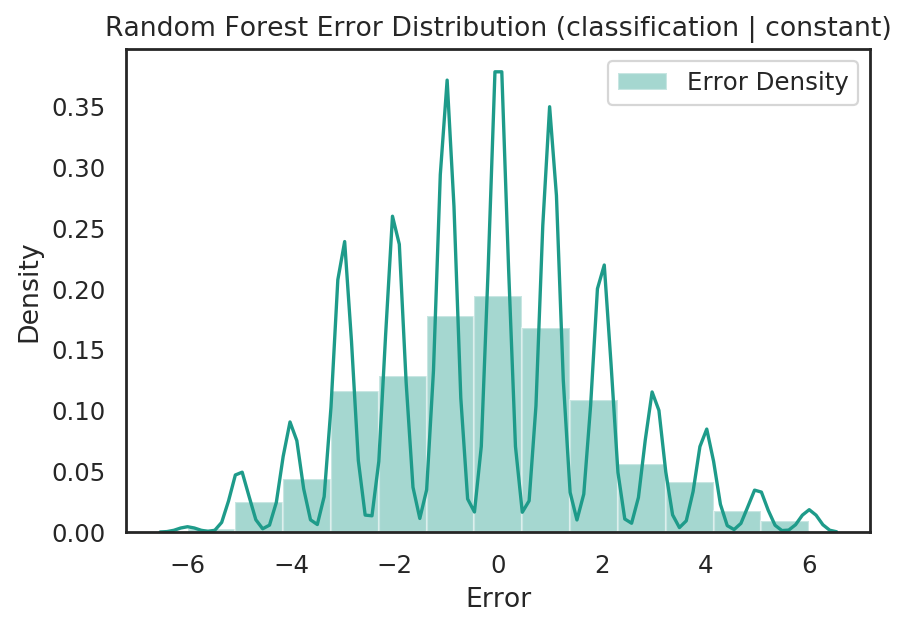

In [8]:
bins = len(np.unique(test_error_distribution)) if classification else None
sns.set(style="white")
sns.distplot(test_error_distribution, color=sns.color_palette("viridis", 10)[5], label="Error Density", bins=bins)
plt.ylabel('Density');
plt.xlabel('Error');
plt.title(f'Random Forest Error Distribution ({label_type} | {splice_type})');
plt.legend();
plt.savefig(error_distribution_save_path);
plt.show();

In [9]:
if not classification:
    sns.set(style="white")
    sns.distplot(test_unbiased_error_distribution, color=sns.color_palette("viridis", 10)[5], label="Error Density")
    plt.ylabel('Density');
    plt.xlabel('Error');
    plt.title(f'Random Forest Unbiased Error Distribution ({label_type} | {splice_type})');
    plt.legend();
    plt.savefig(error_distribution_unbiased_save_path);
    plt.show();

In [10]:
if not classification:
    unbiased_mean = np.mean(test_unbiased_error_distribution)
    unbiased_std = np.std(test_unbiased_error_distribution)
    ci = np.percentile(test_unbiased_error_distribution, [2.5, 97.5])
    
    result += "\n\n"
    result += f"# Estimates\n"
    result += f"Unbiased Mean:\t\t\t{unbiased_mean}\n"
    result += f"Standard Deviation:\t\t{unbiased_std}\n"
    result += f"95% Prediction Interval:\t{unbiased_mean - 1.96 * unbiased_std} to {unbiased_mean + 1.96 * unbiased_std}\n\n"
    result += f""
    result += f"# Estimate from percentiles\n"
    result += f"95% Prediction Interval:\t{ci[0]+unbiased_mean} to {ci[1]+unbiased_mean}\n\n"
    result += f""
    result += f"# Pure PI\n"
    result += f"95% Prediction Interval:\t{-1.96 * unbiased_std} to {1.96 * unbiased_std}\n"


In [11]:
with open(metrics_save_path, "w") as text_file:
    text_file.write(result)

In [12]:
print(result)

Accuracy Train: 0.9998611111111111
Accuracy Test: 0.21243243243243243

Max Size CV: Taken -> 40000, cap -> 40000, available -> 1382400.
Max Size Fit: Taken -> 80000, cap -> 80000, available -> 1382400.
Best Parameters: {'classifier__max_depth': 25, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 40}


